### College Major Selection and Shift Analysis

Author: <a href="https://www.kanit.codes" target="_blank">Kanit Mann</a>

MS Data Science | University of Arizona

Date: September 2025

#### **Project Description**: This project investigates how the most popular and lucrative college majors in the U.S. have changed from 2009–2023, with a special focus on whether wage growth predicts popularity.

#### Executive Summary
- Business Management and Administration, Psychology, and Accounting were the most popular U.S. majors from 2009–2023, with Accounting alone growing by 16.6% over the period, even as other business majors declined.
- Computer Engineering offered the highest median wage and saw a 40% pay increase over ten years; majors with the fastest wage growth also saw the greatest jumps in student interest.
- Students strongly favor majors with rising median earnings, suggesting that shifts in college major choice are closely linked to wage trends in those fields.


Research Question: How Distribution of college majors have changed over time and whether it is related to median earning after graduation

Business Questions:
- How have most popular college majors have change over time in US?
- Do changes in major popularity correspond to changes in the typical earnings for those majors?
- Can we prove that the corresponding shift is due to increased attractiveness in the terms of pay, or vice versa?

|  Years    |     Cohort    |
|  --       |       --      |
| 2009-2024 | All graduates |

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
# Using the only the columns that we need from the IPUMS USA dataset

usecols = [
    'YEAR', 'AGE', 'SEX', 'RACE', 'EDUC', 'EDUCD', 'DEGFIELD', 'DEGFIELDD',
    'EMPSTAT', 'CLASSWKR', 'INCWAGE', 'PERWT'
]
df_grad = pd.read_csv('./data/usa_00001.csv', usecols=usecols)

Understanding the data fields:

| Field Name | Description |Typical Use in Analysis|
|--|--|--|
| YEAR | Census year / survey year |For time trends; critical for year-by-year analysis of majors and earnings.|
| PERWT | Person-level weight |Always used for population statistics - this makes our sample nationally representative!|
| SEX | Sex (1=male, 2=female) |For demographic analysis (gender splits, etc.).|
| AGE | Age in years |To define your analysis cohort (e.g., recent grads = ages 22–29).|
| RACE | General race code |For basic racial demographic splits/analysis.|
| EDUC | General education attainment |For simple cutoffs (e.g., high school/some college/bachelor’s+).|
| EDUCD | Detailed education attainment |For precise cohort selection (e.g., exactly bachelor’s, associate, advanced degrees).|
| DEGFIELD | General field of college major |For basic broad major groupings (e.g., “Engineering,” “Business,” etc.).|
| DEGFIELDD | Detailed field of degree |For fine-grained analysis (e.g., separates “Mechanical Engineering” from “Chemical Engineering”).|
| EMPSTAT | Employment status |Filter for employed/unemployed/not-in-labor-force—crucial if you want only employed grads.|
| CLASSWKR | Class of worker (general) |Public/private/self-employed worker distinctions.|
| INCWAGE | Wage and salary income |Main variable for annual earnings; your “target” value for most of the pay analysis|

This dataset is data courtesy of IPUMS USA, University of Minnesota, [www.ipums.org](www.ipums.org). 

Note: ` My analyses exclude 2020 due to pandemic survey methodology changes as per Census recommendations.`

-> The ACS 2020 PUMS file uses experimental weights due to COVID-19 survey disruptions. For accurate historical comparisons, 2020 results should be interpreted with caution and are excluded from time trend analysis. For details, see Census Bureau’s COVID-19 PUMS guidance.

In [56]:
# Let's take a look at our data

print(df_grad.head())
print(df_grad.info())
print(df_grad.isnull().sum())
print(df_grad['YEAR'].value_counts())


   YEAR  PERWT  SEX  AGE  RACE  EDUC  EDUCD  DEGFIELD  DEGFIELDD  EMPSTAT  \
0  2009    3.0    1   51     1     6     63         0          0        3   
1  2009   22.0    2   64     1     7     71         0          0        1   
2  2009   21.0    1   68     1     5     50         0          0        1   
3  2009   30.0    2   61     2     6     63         0          0        1   
4  2009   32.0    1   38     2     6     63         0          0        1   

   CLASSWKR  INCWAGE  
0         0        0  
1         2    27100  
2         2    22100  
3         2     6000  
4         2    14000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44562282 entries, 0 to 44562281
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   YEAR       int64  
 1   PERWT      float64
 2   SEX        int64  
 3   AGE        int64  
 4   RACE       int64  
 5   EDUC       int64  
 6   EDUCD      int64  
 7   DEGFIELD   int64  
 8   DEGFIELDD  int64  
 9   EMPSTAT    int6

                AGE           SEX
count  4.456228e+07  4.456228e+07
mean   4.126657e+01  1.511142e+00
std    2.366349e+01  4.998758e-01
min    0.000000e+00  1.000000e+00
25%    2.100000e+01  1.000000e+00
50%    4.200000e+01  2.000000e+00
75%    6.000000e+01  2.000000e+00
max    9.700000e+01  2.000000e+00


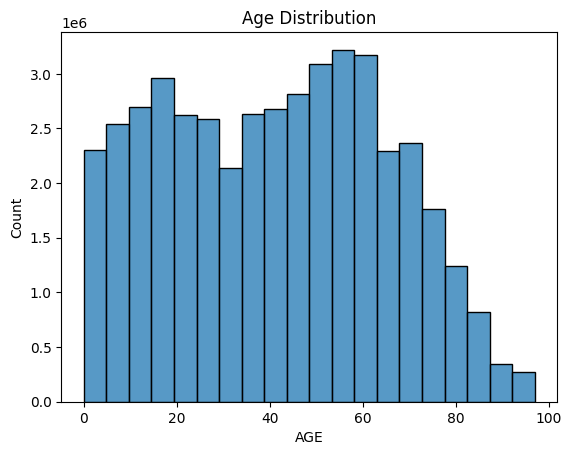

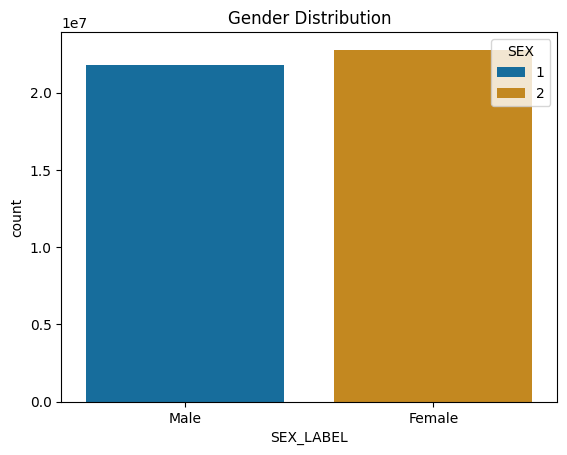

In [57]:
# Let's take a look at the age and sex distribution

print(df_grad[['AGE', 'SEX']].describe())
sns.histplot(df_grad['AGE'], bins=20)
plt.title('Age Distribution')
plt.show()

sex_labels = {1: 'Male', 2: 'Female'}
df_grad['SEX_LABEL'] = df_grad['SEX'].map(sex_labels)
sns.countplot(x='SEX_LABEL', data=df_grad, palette='colorblind', hue='SEX')
plt.title('Gender Distribution')
plt.show()

In [69]:
# Mapping the degree field codes to the degree field names, the original names can also be found in the codebook
from degfield_map import degfield_map

In [70]:
# Extracting the degree field names from the degree field codes
df_grad['major_str'] = df_grad['DEGFIELDD'].map(degfield_map)

In [71]:
# Filtering our the data to only include employed graduates with positive wages
data = df_grad[(df_grad['INCWAGE'] > 0) & (df_grad['EMPSTAT'] == 1)]


In [72]:
# Let's take a look at the major distribution now
print(data['major_str'].value_counts().head())


major_str
Business Management and Administration    442266
Psychology                                313573
Nursing                                   296810
General Business                          280951
Accounting                                265697
Name: count, dtype: int64


In [62]:
# Starting with EDA
# A. First, we will try to see the distribution of grads per major over time

major_year_ct = (
    data
    .groupby(['YEAR', 'major_str'], as_index=False)
    .agg({'PERWT': 'sum'})
    .rename(columns={'PERWT':'num_grads'})
)

In [63]:
print(major_year_ct.head())

   YEAR                         major_str  num_grads
0  2009                        Accounting  1633263.0
1  2009                 Actuarial Science    10347.0
2  2009  Advertising and Public Relations   159970.0
3  2009             Aerospace Engineering    91430.0
4  2009            Agricultural Economics    36652.0


In [64]:
# Top 10 most popular majors over all years
top_majors = major_year_ct.groupby('major_str')['num_grads'].sum().sort_values(ascending=False).head(10).index.tolist()


In [65]:
print(top_majors)

['Business Management and Administration', 'Psychology', 'General Business', 'Nursing', 'Accounting', 'Biology', 'General Education', 'Elementary Education', 'English Language and Literature', 'Computer Science']


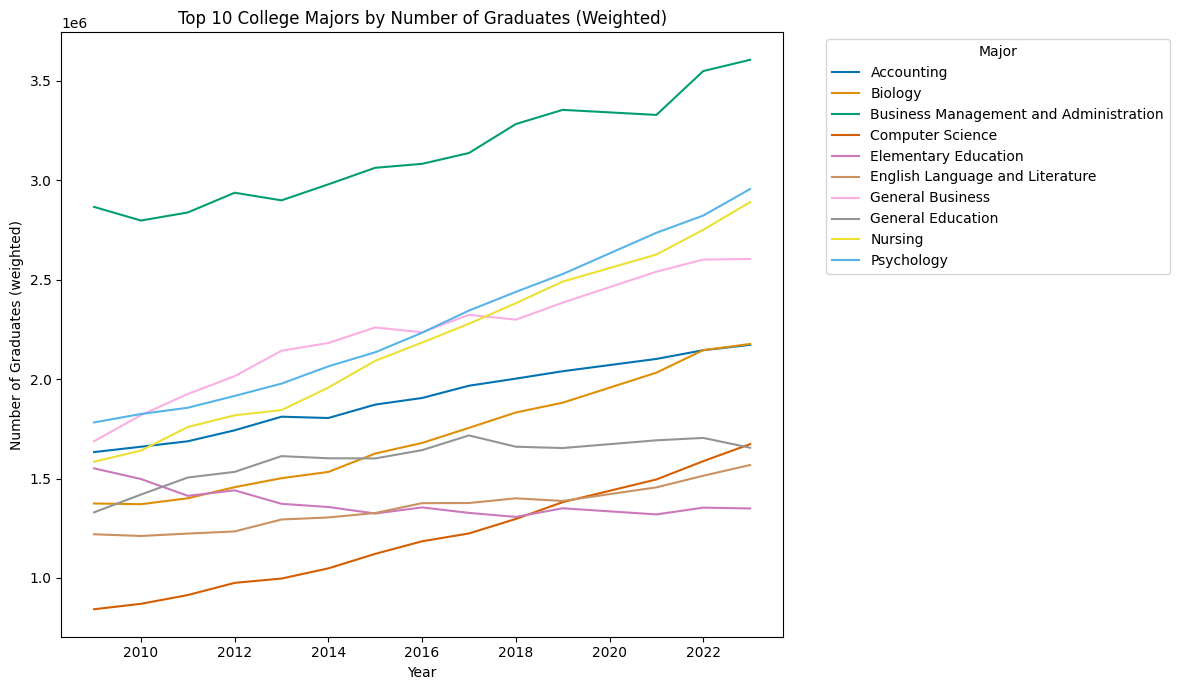

In [66]:
# Let's plot the top 10 most popular majors over time

plt.figure(figsize=(12, 7))
sns.lineplot(data=major_year_ct[major_year_ct['major_str'].isin(top_majors)],
             x='YEAR', y='num_grads', palette='colorblind', hue='major_str')
plt.title('Top 10 College Majors by Number of Graduates (Weighted)')
plt.ylabel('Number of Graduates (weighted)')
plt.xlabel('Year')
plt.legend(title='Major', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

|EDA|The Story Behind the Plot|
|--|--|
|Accounting remained college major favourite, and even grew by 16.6% over 10 years.|Accounting shows a robust, counter-cyclical trend even as other business fields declined, like General Business Studies.|
|Computer Engineering, Biology and Psychology also saw steady growth in as college major favourites| The rise in Biology and Psychology can be understood due to increased awareness in healthcare, and mental wellbeing.|

In [67]:
# b) Now, let's try to visualize the median Salary by Major and Year

wage_summary = (
    df_grad.groupby(['YEAR', 'major_str'], as_index=False)
    .agg(median_wage=('INCWAGE', 'median'))
    .reset_index()
    .rename(columns={0:'median_wage'})
)

print(wage_summary.head())

   index  YEAR                         major_str  median_wage
0      0  2009                        Accounting      47000.0
1      1  2009                 Actuarial Science      65000.0
2      2  2009  Advertising and Public Relations      35000.0
3      3  2009             Aerospace Engineering      67000.0
4      4  2009            Agricultural Economics      40000.0


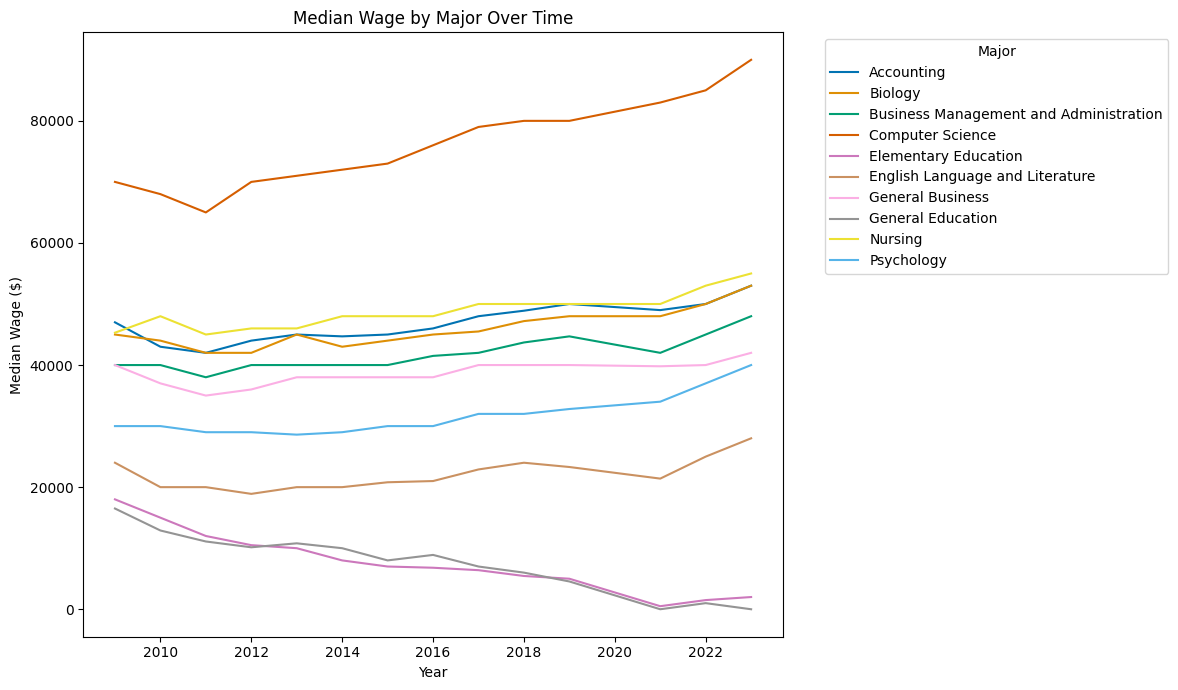

In [68]:
plt.figure(figsize=(12, 7))
sns.lineplot(data=wage_summary[wage_summary['major_str'].isin(top_majors)], x = 'YEAR', y = 'median_wage', palette='colorblind', hue = 'major_str')
plt.title('Median Wage by Major Over Time')
plt.ylabel('Median Wage ($)')
plt.xlabel('Year')
plt.legend(title='Major', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

|EDA|The Story Behind the Plot|
|--|--|
|Computer Engineering remained the highest paying job (median) for 10 years, and even increases by 40%. | This is a signal of persistent market demand. |
|Accounting, Biology, and Business Administration also remained competetively paid| This is a signal of persistent market demand. |

Actionable Insights from the EDA:	
- Universities may consider investing further in Computer Engineering and Accounting programs, as both student demand and wage outcomes remain high.
- The decline in General Business Studies suggests a possible shift in employer or student preferences toward more specialized degrees.

Limitations:
- Data excludes 2020 due to COVID-19 survey issues.
- Does not address lag effects or causality direction formally.
- Graduate degrees not separated from undergrad in this cut.

Next Steps:
 - [ ] Explore causal tests, or lag effects
 - [ ] Disaggregate by race, gender, or degree level.
 - [ ] Compare outcomes for recent vs. older graduates.